# **IMPORT LIBRARIES**

In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!nvidia-smi

Sat Sep  7 13:55:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [6]:
%%capture
!pip install transformers==4.19.2
!pip install rouge_score

In [7]:
!pip install keybert

  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 11.8 MB/s eta 0:00:00
Using cached transformers-4.44.2-py3-none-any.whl (9.5 MB)
Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.19.2
    Uninstalling transformers-4.19.2:
      Successfully uninstalled transformers-4.19.2


In [8]:
from datasets import load_metric, load_dataset
import torch
from datasets import Dataset
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from transformers import LEDForConditionalGeneration, LEDTokenizer, AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import transformers
from transformers import BartForConditionalGeneration, BartTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from keybert import KeyBERT

# **IMPORT DATA AND PREPROCESSING**

In [9]:
df = pd.read_csv('/content/drive/MyDrive/Code cycle/wikiHow.csv')

In [10]:
df.head()

,title,heading,paragraph
0,3 Ways to Put on a Medical Mask - wikiHow,Understand what a medical mask protects you from.,Medical or surgical masks are intended to cove...
1,3 Ways to Put on a Medical Mask - wikiHow,Know the difference between a medical mask and...,An N95 respirator is a device used by health p...
2,3 Ways to Put on a Medical Mask - wikiHow,Clean your hands.,"Before touching a clean medical mask, wash you..."
3,3 Ways to Put on a Medical Mask - wikiHow,Check the medical mask for defects.,Once youve taken a new (unused) medical mask f...
4,3 Ways to Put on a Medical Mask - wikiHow,Orient the top of the mask properly.,In order for the mask to fit as close to your ...


In [11]:
print(df.shape)
df = df.dropna()
print(df.shape)

(60364, 3)
(59762, 3)


In [12]:
df = df.drop_duplicates()
print(df.shape)

(49075, 3)


In [13]:
df['length'] = df.paragraph.map(lambda x: len(x.split(" ")))

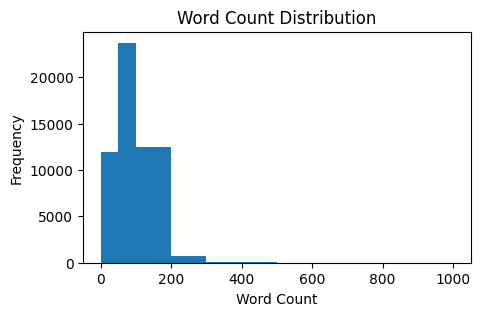

In [14]:
numOfWords = df.length

fig = plt.figure(figsize =(5, 3))
plt.hist(numOfWords.to_numpy(), bins = [0,50,100,200,300,500,1000])
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

In [15]:
tempDf = df[df.length <= 200]
tempDf.shape

(48263, 4)

# **SUB-TITLE GENERATION**

In [16]:
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [17]:
max_input_length = 1024
max_output_length = 64
batch_size = 16

def process_data_to_model_inputs (batch):
    # tokenize the inputs and labels
    inputs = tokenizer(
        batch["paragraph"],
        padding = "max_length",
        truncation = True,
        max_length=max_input_length,
    )
    outputs = tokenizer(
        batch["heading"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create > global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [[0 for _ in range(len(batch["input_ids"][0]))]]

    # since above lists are references, the following line changes the index for all samples batch["global_attention_mask"][0][0] = 1
    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]
    return batch

In [18]:
train, validate, test = np.split(tempDf.sample(frac=1, random_state=42), [int(.6*len(df)), int(.7*len(df))])
print(train.shape)
print(validate.shape)
print(test.shape)

(29445, 4)
(4907, 4)
(13911, 4)


In [19]:
validate = validate[:20]
print(validate.shape)

(20, 4)


In [20]:
train_dataset = Dataset.from_pandas(train)
validate_dataset = Dataset.from_pandas(validate)
test_dataset = Dataset.from_pandas(test)

In [21]:
train_dataset = train_dataset.map(process_data_to_model_inputs, batched=True, batch_size=batch_size, remove_columns=["title","heading","paragraph","length","__index_level_0__" ],)

Map:   0%|          | 0/29445 [00:00<?, ? examples/s]

In [22]:
validate_dataset = validate_dataset.map(process_data_to_model_inputs, batched=True, batch_size=batch_size, remove_columns=["title","heading","paragraph","length","__index_level_0__" ],)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [23]:
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],)
validate_dataset.set_format(type="torch",columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],)

In [24]:
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)
led.config.num_beams = 2
led.config.max_length = 64
led.config.min_length = 2
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3
rouge = load_metric("rouge")


def compute_metrics (pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    return {
    "rouge2_precision": round(rouge_output.precision, 4),
    "rouge2_recall": round(rouge_output.recall, 4),
    "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


transformers.logging.set_verbosity_info()

training_args = Seq2SeqTrainingArguments( predict_with_generate=True,
evaluation_strategy="steps",
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
output_dir="./",
logging_steps=5,
eval_steps=10,
save_steps=10,
save_total_limit=2,
gradient_accumulation_steps=4,
num_train_epochs=10
)

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [25]:
trainer = Seq2SeqTrainer(
model=led,
tokenizer=tokenizer,
args=training_args,
compute_metrics=compute_metrics,
train_dataset=train_dataset,
eval_dataset=validate_dataset,
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 29,445
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 4,600
  Number of trainable parameters = 161,844,480


KeyboardInterrupt: 

In [26]:
sample_paragraph = "The reason why I loved the top-down culture at Apple is that important decisions are taken faster. Having an expert giving you green light or not keeps the momentum. How many times in a bottom-up culture do we spend weeks and weeks, sometimes even months, trying to get alignment with +10 people, because every single person needs to agree with the point of view? It is exhausting. So again, my experience is that having that one leader to look up to to help guide decisions is time-saving, it helps us focus on the design craft, instead of project management."
data = [sample_paragraph]
df = pd.DataFrame(data, columns=['paragraph'])
df['paragraph'][0]
df_test = Dataset.from_pandas(df)
df_test

Dataset({
    features: ['paragraph'],
    num_rows: 1
})

In [27]:
# load tokenizer
tokenizer = LEDTokenizer.from_pretrained("/content/drive/MyDrive/Code cycle/checkpoint-100")
model = LEDForConditionalGeneration.from_pretrained("/content/drive/MyDrive/Code cycle/checkpoint-100").to("cuda").half()
def generate_answer(batch):
    inputs_dict = tokenizer(batch["paragraph"], padding="max_length", max_length=512, return_tensors="pt", truncation=True)
    input_ids = inputs_dict.input_ids.to("cuda")
    attention_mask = inputs_dict.attention_mask.to("cuda")
    global_attention_mask = torch.zeros_like(attention_mask)

    # put global attention on token
    # global_attention_mask[:, 0] = 1
    predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
    batch["generated_heading"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    return batch
result = df_test.map(generate_answer, batched=True, batch_size=2)

loading file vocab.json
loading file merges.txt
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file tokenizer.json
loading configuration file /content/drive/MyDrive/Code cycle/checkpoint-100/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "id2label":

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "min_length": 2,
  "no_repeat_ngram_size": 3,
  "num_beams": 2,
  "pad_token_id": 1,
  "use_cache": false
}

Input ids are automatically padded from 512 to 1024 to be a multiple of `config.attention_window`: 1024


In [28]:
result["generated_heading"]

['Have a leader to guide your decisions.']

# **SUMMARY GENERATION**

In [29]:
# Load pre-trained BART model and tokenizer
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-cnn/snapshots/37f520fa929c961707657b28798b30c003dd100b/config.json
Model config BartConfig {
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "force_bos_token_to_be_generated": true,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1"

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-cnn/snapshots/37f520fa929c961707657b28798b30c003dd100b/model.safetensors
Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 142,
  "min_length": 56,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}

All model checkpoint weights were used when initializing BartForConditionalGeneration.

All the weights of BartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large-cnn.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BartForConditionalGeneration for predictions without further training.


generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-cnn/snapshots/37f520fa929c961707657b28798b30c003dd100b/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 142,
  "min_length": 56,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}



vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-cnn/snapshots/37f520fa929c961707657b28798b30c003dd100b/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-cnn/snapshots/37f520fa929c961707657b28798b30c003dd100b/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-cnn/snapshots/37f520fa929c961707657b28798b30c003dd100b/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--bart-large-cnn/snapshots/37f520fa929c961707657b28798b30c003dd100b/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-large-cnn",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_l

In [30]:
# Example paragraph
paragraph = "In recent years, artificial intelligence (AI) has made significant strides in various industries, revolutionizing the way we live and work. From autonomous vehicles to personalized recommendations, AI-powered solutions have enhanced efficiency and productivity. However, with these advancements come concerns about ethics, privacy, and the future of employment. As AI continues to evolve, it is essential to strike a balance between innovation and responsibility."

# Tokenize the paragraph
inputs = tokenizer(paragraph, max_length=1024, return_tensors="pt", truncation=True)

# Generate summary
summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Summary: ", summary)

Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 142,
  "min_length": 56,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}



Summary:  Artificial intelligence (AI) has made significant strides in various industries, revolutionizing the way we live and work. With these advancements come concerns about ethics, privacy, and the future of employment. As AI continues to evolve, it is essential to strike a balance between innovation and responsibility.


# **KEYWORD GENERATION**

In [31]:
# List of paragraphs
documents = [paragraph]

# Initialize TF-IDF Vectorizer (without max_df and min_df for single document)
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the paragraphs
tfidf_matrix = tfidf.fit_transform(documents)

# Get feature names (tags)
tags = tfidf.get_feature_names_out()

print("Tags: ", tags)

Tags:  ['advancements' 'ai' 'artificial' 'autonomous' 'balance' 'come' 'concerns'
 'continues' 'efficiency' 'employment' 'enhanced' 'essential' 'ethics'
 'evolve' 'future' 'industries' 'innovation' 'intelligence' 'live'
 'personalized' 'powered' 'privacy' 'productivity' 'recent'
 'recommendations' 'responsibility' 'revolutionizing' 'significant'
 'solutions' 'strides' 'strike' 'various' 'vehicles' 'way' 'work' 'years']


In [32]:
# Initialize KeyBERT model
model_kb = KeyBERT('distilbert-base-nli-mean-tokens')

# Extract keywords
keywords = model_kb.extract_keywords(paragraph, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=5)

print("Keywords: ", keywords)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--distilbert-base-nli-mean-tokens/snapshots/2781c006adbf3726b509caa8649fc8077ff0724d/config.json
Model config DistilBertConfig {
  "_name_or_path": "sentence-transformers/distilbert-base-nli-mean-tokens",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.44.2",
  "vocab_size": 30522
}



model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--sentence-transformers--distilbert-base-nli-mean-tokens/snapshots/2781c006adbf3726b509caa8649fc8077ff0724d/model.safetensors
All model checkpoint weights were used when initializing DistilBertModel.

All the weights of DistilBertModel were initialized from the model checkpoint at sentence-transformers/distilbert-base-nli-mean-tokens.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--distilbert-base-nli-mean-tokens/snapshots/2781c006adbf3726b509caa8649fc8077ff0724d/config.json
Model config DistilBertConfig {
  "_name_or_path": "sentence-transformers/distilbert-base-nli-mean-tokens",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.44.2",
  "vocab_size": 30522
}



vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sentence-transformers--distilbert-base-nli-mean-tokens/snapshots/2781c006adbf3726b509caa8649fc8077ff0724d/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--distilbert-base-nli-mean-tokens/snapshots/2781c006adbf3726b509caa8649fc8077ff0724d/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--distilbert-base-nli-mean-tokens/snapshots/2781c006adbf3726b509caa8649fc8077ff0724d/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--distilbert-base-nli-mean-tokens/snapshots/2781c006adbf3726b509caa8649fc8077ff0724d/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sentence-transformers--distilbert-base

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Keywords:  [('industries revolutionizing', 0.5846), ('productivity advancements', 0.3819), ('enhanced efficiency', 0.3807), ('innovation responsibility', 0.369), ('revolutionizing way', 0.36)]
